In [17]:
import numpy as np
import pandas as pd
from scipy.optimize import linprog 
from twinsvm import twinsvmclassifier
import random
import sys
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn.model_selection import train_test_split

In [2]:
def optimize(X,y,delta, alpha):
    (m,n) = X.shape
    K = (y == 0).sum()
    M = (y == 1).sum()
    A = np.zeros((n,m))
    B = np.zeros((m))
    for i in range(m):
        if y[i] == 0:     
            V = np.zeros((1,m))
            V[0][i] = -1  #qi
            A = np.vstack((A,V))
            for j in range(n):
                A[j][i] = X[i][j]
                B[i] = -delta
        else:  
            V = np.zeros((1,m))
            V[0][i] = -1 #qi
            A = np.vstack((A,V)) 
            for j in range(n):
                A[j][i] = -1*X[i][j]
                B[i] = -delta
    A = np.vstack((A, np.zeros((n,m))))   # dimension of A is 2n+2m+n, m
    s1 = np.zeros((n+m+n))
    s2 = np.zeros((n+m+n))
    W = np.zeros((n+m+n))
    for i in range(m):
        if y[i] == 0:
            W[i+n] = 1/K                  #qi
            s2[n+i] = 1                   #class 0 K
        else:
            W[i+n] = 1/M                  #qi
            s1[n+i] = 1                   #class 1 M
    for i in range(n):
        W[n+m+i] = alpha   ##########
    A = A.T
    #Ax=B the equality constraints
    C = np.zeros((2*n,n+m+n))
    D = np.zeros((2*n+m+2))
    D[2*n+m+2-1] = K-1+0.5   #s2 class 0
    D[2*n+m+2-2] = M-1+0.5   #s1 class 1
    for i in range (n):
        C[i,i] = 0#1
        C[i+n,i] = 0#-1
        C[i, i+n+m] = 0#-1
        C[i+n, i+n+m] = 0#-1
        # Cx<=D
    for i in range(m):
        s3 = np.zeros((n+m+n))
        s3[n+i] = -1  
        C = np.vstack((C, s3))
    C = np.vstack((C, s1))
    C = np.vstack((C, s2))
    A = np.vstack((A,C))
    B = np.hstack((B,D))      
    res = linprog(W, A_ub=A, b_ub=B,bounds=(None, None),method = 'simplex', options = {'tol':1e-8}) 
    wd = res.x[:n]
    qi = np.zeros((m))
    for i in range(m):
        qi[i] = res.x[i+n]
    print("wd_normal:"+str(wd))
    return np.matrix(wd),None

In [3]:
def y_hat(X, weights, delta, y,twin_svm_en,clf):
    if(twin_svm_en == 0):
        n = len(X)
        y_res = np.asarray(np.dot(weights,X.T))
        y_res1 = np.asarray(np.dot(weights, X.T))
#         print("Wy_hat:"+str(weights))
#         print("WTX:"+str(y_res))
#         print(y_res>-1*delta)
        for i in range(n):
            if y_res1[0][i] >= -0.00001:
                y_res[0][i] = 1
            if y_res1[0][i] <= 0.00001:
                y_res[0][i] = 0
    else:
        Xx = X[:,1:len(X[0])]
        y_pred = clf.predict(Xx)
        y_res = np.array([y_pred])
#     print("y_res..y_hat:"+str(y_res))
    return y_res[0]



In [4]:
def classes(y,y_res):
    C1 = []
    C2 = []
    C3 = []
    C4 = []
    y = y.astype(int)
    y_res = y_res.astype(int)
    for i in range(len(y_res)): 
        if y[i] == 0 and y_res[i] == 0:
            C1.append(i)
        if y[i] == 1 and y_res[i] == 1:
            C2.append(i)
        if y[i] == 1 and y_res[i] == 0:
            C3.append(i)
        if y[i] == 0 and y_res[i] == 1:
            C4.append(i)
    return C1, C2, C3, C4

In [5]:
#plane1 < plane2 => class 0
#plane1 >= plane2 => class 1
# plane1-plane2 < 0 => class 0 
# plane1-plane2 >= 0 => class 1
#C3 => desired 1 we get 0
#so plane1 < plane2 
#   plane1-plane2 < 0
#   Wa decided by min(plane1-plane2)
def find_Wa(X, C3, weights):
    res = sys.maxsize
    y=0
    ans =0
    for i in C3:
        if(weights.shape[1]==X.shape[1]):
            y = np.asarray(np.dot(weights, X[i].T))
            res = min(res, y[0][0])
            ans = 1-res+0.0001
        else:
            print("twinsvm")
            XX = X[i,1:len(X[i])]
            weights = np.asarray(weights)
            X= np.asarray(X)
            b1 = weights[0][0]
            w1 = weights[0][1:X.shape[1]]
            b2 = weights[0][X.shape[1]]
            w2 = weights[0][X.shape[1]+1:2*(X.shape[1])]
            w1mod = np.linalg.norm(w1)
            w2mod = np.linalg.norm(w2)
            y1 = np.dot(XX,w1)+ b1
            y2 = np.dot(XX,w2)+ b2
            distFromPlane1 = y1/w1mod 
            distFromPlane2 = y2/w2mod 
            dis = (distFromPlane1 - distFromPlane2)
            res = min(res, dis)
            ans = -res+0.000001
    return ans

In [6]:
#C4 => desired 0 we get 1
#so plane1 >= plane2
#   plane1-plane2 >= 0
#   Wb decided by max(plane1-plane2)
def find_Wb(X, C4, weights):
    res = -sys.maxsize-1
    y=0
    ans = 0
    for i in C4:
        if(weights.shape[1]==X.shape[1]):
            y = np.asarray(np.dot(weights, X[i].T))
            res = max(res, y[0][0])
            ans = -1-res-0.0000001
        else:
            print("twinsvm")
            XX = X[i,1:len(X[i])]
            weights = np.asarray(weights)
            X= np.asarray(X)
            b1 = weights[0][0]
            w1 = weights[0][1:X.shape[1]]
            b2 = weights[0][X.shape[1]]
            w2 = weights[0][X.shape[1]+1:2*(X.shape[1])]
            w1mod = np.linalg.norm(w1)
            w2mod = np.linalg.norm(w2)
            y1 = np.dot(XX,w1)+ b1
            y2 = np.dot(XX,w2)+ b2
            distFromPlane1 = y1/w1mod 
            distFromPlane2 = y2/w2mod 
            dis = (distFromPlane1 - distFromPlane2)
            res = max(res, dis)
            ans = -res-0.000001
    return ans


In [7]:
def quantize(a,b,twin_node,XX):
    if(twin_node == 0):
        if(a.shape[1] < b.shape[1]): 
            a = np.hstack((a,np.zeros((a.shape[0],b.shape[1]-a.shape[1]))))
#             print("a:"+str(a))
        res = np.dot(a,b.T)
        res1 = np.dot(a,b.T)
#         print("res_before_quant:"+str(res))
        # res = res.astype(int)
        # print("resint:"+str(res))
        for j in range(res.shape[0]):
            if(res1[j][0] >= -0.00001):
                res[j][0] = 1
            if(res1[j][0] <= +0.00001):
                res[j][0] = 0
            # else:
            #     print("delta condition not met")
#         print("res_after_quant:"+str(res))
    else:
        b1 = b[0][0]
        w1 = b[0][1:XX.shape[1]].reshape(XX.shape[1]-1,1)
        b2 = b[0][XX.shape[1]]
        w2 = b[0][XX.shape[1]+1:2*(XX.shape[1])].reshape(XX.shape[1]-1,1)
        wAB = b[0][2*(XX.shape[1]):b.shape[1]].reshape(-1,1)
        Xd = a[:,1:XX.shape[1]]
        if(a.shape[1] > XX.shape[1]):
            XAB = a[:,XX.shape[1]:a.shape[1]]
        else:
            print("XAB empty")
            XAB = np.zeros(wAB.T.shape)
        print("twin_svm_res")
        w1mod = np.linalg.norm(w1)
        w2mod = np.linalg.norm(w2)
        y1 = np.dot(Xd,w1)+ b1*np.ones((XX.shape[0],1))
        y2 = np.dot(Xd,w2)+ b2*np.ones((XX.shape[0],1))
        distFromPlane1 = y1/w1mod 
        distFromPlane2 = y2/w2mod 
#         print("wAB:"+str(wAB))
#         print("XAB:"+str(XAB))
#         print("wABSHAPE:"+str(wAB.shape))
#         print("XABSHAPE:"+str(XAB.shape))
        res = (distFromPlane1 - distFromPlane2) + np.dot(XAB,wAB)
#         print("res_twin_bef:"+str(res))
        for j in range(res.shape[0]):
            if(res[j][0] >= 0):
                res[j][0] = 1
            elif(res[j][0] < 0):
                res[j][0] = 0
#         print("res_twin_aft:"+str(res))
    return res

In [8]:
class Neuron:
    
    def __init__(self,n,twin_node):
        self.X = np.zeros((1,n))
        self.inp = n
        self.A = None
        self.B = None
        self.twin_node = twin_node
        self.weight = 0
        
    def insert(self,neuron_type, weight):     #### Type is a restricted variable, Type was always set to A, weigth to 1
        if neuron_type == 'A':
            self.A = Neuron(self.inp,0)
            self.A.weight = weight
            self.X = np.hstack((self.X, np.array([[weight]])))
        else:
            self.B = Neuron(self.inp,0)
            self.B.weight = weight
            self.X = np.hstack((self.X, np.array([[weight]])))
            
    def calculate(self,XX):
        if self.A != None and self.B != None:
            print("AB")
            y_1 = self.A.calculate(XX)
            y_2 = self.B.calculate(XX)
#             print("y_1:"+str(y_1))
#             print("y_2:"+str(y_2))
            res = quantize(np.hstack((XX, y_1, y_2)),self.X,self.twin_node,XX)
            return res
        elif self.A != None:
            print("A")
            y_1 = self.A.calculate(XX)
#             print("y_1:"+str(y_1))
            res = quantize(np.hstack((XX, y_1)),self.X,self.twin_node,XX)
            return res
        elif self.B != None:
            print("B")
            y_2 = self.B.calculate(XX)
#             print("y_2:"+str(y_2))
            res = quantize(np.hstack((XX, y_2)),self.X,self.twin_node,XX)
            return res
        else:
            print("no child node")
            res = quantize(XX,self.X,self.twin_node,XX)
            return res

    def calculate_till_depth_d(self,XX,d,count_depth):
        count_depth = count_depth + 1
        if(count_depth == d): #stop calculation at this layer
            stop_cal = 1
        else:
            stop_cal = 0
        if(stop_cal == 0):
            if self.A != None and self.B != None:
                print("AB")
                y_1 = self.A.calculate_till_depth_d(XX,d,count_depth)
                y_2 = self.B.calculate_till_depth_d(XX,d,count_depth)
#                 print("y_1:"+str(y_1))
#                 print("y_2:"+str(y_2))
                res = quantize(np.hstack((XX, y_1, y_2)),self.X,self.twin_node,XX)
                return res
            elif self.A != None:
                print("A")
                y_1 = self.A.calculate_till_depth_d(XX,d,count_depth)
#                 print("y_1:"+str(y_1))
                res = quantize(np.hstack((XX, y_1)),self.X,self.twin_node,XX)
                return res
            elif self.B != None:
                print("B")
                y_2 = self.B.calculate_till_depth_d(XX,d,count_depth)
#                 print("y_2:"+str(y_2))
                res = quantize(np.hstack((XX, y_2)),self.X,self.twin_node,XX)
                return res
            else:
                print("no child node")
                res = quantize(XX,self.X,self.twin_node,XX)
                return res
        else:
            print("we have stopped calculating")
#             print("XX:"+str(XX))
#             print("self.X:"+str(self.X))
            res = quantize(XX,self.X,self.twin_node,XX)
            return res

In [9]:
def get_twin_classifier(X,y):
    while(True):
        C1value = random.uniform(0,5)
        C2value = random.uniform(0,5)
        params = {'Epsilon1': 0.1, 'Epsilon2': 0.1, 'C1': C1value, 'C2': C2value,'kernel_type':0,'kernel_param': 2}
        clf=twinsvmclassifier(**params)
        clf.fit(X,y)
        y_pred = clf.predict(X)
        C1,C2,C3,C4 = classes(y, y_pred)
        if(not(len(C1)==0 or len(C2)==0)):
#             print("#######")
#             print("C1 points:")
#             print(C1)
#             for i in C1:
#                 print(X[i])
#             print("C2 points:")
#             print(C2)
#             for i in C2:
#                 print(X[i])
#             print("C3 points:")
#             print(C3)
#             for i in C3:
#                 print(X[i])
#             print("C4 points:")
#             print(C4)
#             for i in C4:
#                 print(X[i])
#             print("#######")
#             print("wb:"+str(clf.getwb()))
            return clf  

In [10]:
def twin(X,y):
    XX = X[:,1:len(X[0])]
    yy = y
#     print("XX:"+str(XX))
#     print("yy:"+str(yy))
    clf = get_twin_classifier(XX, yy)
    clf.fit(XX,yy)
    w1,b1,w2,b2 = clf.getwb()
    w1 = w1.T
    w2 = w2.T
    b1 = np.array([b1])
    b2 = np.array([b2])
    wd = np.hstack((b1,w1,b2,w2))
#     print("wdtwin:"+str(wd))
    return wd,clf

In [11]:
def addneuron_A(X, y, W, C1, C3, C4, delta, alpha, curr_Neuron):
    n = X.shape[1]
#     print('A')
#     print("X:"+str(X))
    m = len(C1) + len(C3) + len(C4)
# #     print(m)
#     print("C1:")
#     print((C1))
#     for i in range(len(C1)):
#         print(X[C1[i]])
#     print("C3:")
#     print((C3))
#     for i in range(len(C3)):
#         print(X[C3[i]])
#     print("C4:")
#     print((C4))
#     for i in range(len(C4)):
#         print(X[C4[i]])
    y_A = np.zeros((m))
    X_A = np.zeros((m, n))
    for i in range(len(C1)):
        X_A[i] = X[C1[i]]
        y_A[i] = 0

    for i in range(len(C3)):
        X_A[i + len(C1)] = X[C3[i]]
        y_A[i + len(C1)] = 1

    for i in range(len(C4)):
        X_A[i + len(C1)+ len(C3)] = X[C4[i]]
        y_A[i + len(C1)+ len(C3)] = 0
#     print("X_A:")
#     print(X_A)
#     print("y_A:")
#     print(y_A)
    # print("X:"+str(X))
    # print("C3:"+str(C3))
#     print("W:"+str(W))
    Wa = find_Wa(X, C3, W)
#     print("Wa:"+str(Wa))
#         print(Wa)    
    
    
    C1_new = list()
    C3_new = list()
    C4_new = list() 
    for i in range(X.shape[0]):
        if i in C1:
            for j in range(X_A.shape[0]):
                if np.array_equal(X_A[j],X[i]):
                    C1_new.append(j)
        if i in C3:
            for j in range(X_A.shape[0]):
                if np.array_equal(X_A[j],X[i]):
                    C3_new.append(j)
        if i in C4:
            for j in range(X_A.shape[0]):
                if np.array_equal(X_A[j],X[i]):
                    C4_new.append(j)
#     print("C1_new:"+str(C1_new))
#     print("C3_new:"+str(C3_new))
#     print("C4_new:"+str(C4_new))
    C1 = C1_new
    C3 = C3_new
    C4 = C4_new
    
    
    W_A,clf = optimize(X_A, y_A,delta, alpha)
    y_res = y_hat(X_A, W_A, delta, y_A,0,clf)
    Cc1, Cc2, Cc3, Cc4 = classes(y_A, y_res)
#     print("Cc1:"+str(Cc1))
#     print("Cc2:"+str(Cc2))
#     print("Cc3:"+str(Cc3))
#     print("Cc4:"+str(Cc4))
    # twin_svm_enable =int(len(Cc1)==0 or len(Cc2)==0)
    twin_svm_enable = 0
    print("twin_svm_enable:"+str(twin_svm_enable))
    if(twin_svm_enable):
        W_A,clf = twin(X_A,y_A)
    curr_Neuron.insert('A', Wa)
    curr_Neuron.A.X = W_A
    curr_Neuron.A.twin_node = twin_svm_enable
    return X_A, y_A, W_A,twin_svm_enable,clf


In [12]:
def addneuron_B(X, y, W, C2, C3, C4, delta, alpha, curr_Neuron):
    n = X.shape[1]
    print('B')
#     print("X:"+str(X))
    m = len(C2) + len(C3) + len(C4)
    # print(m)
    y_B = np.zeros((m))
    X_B = np.zeros((m, n))
#         y_B = []
    print("C2:")
#     print((C2))
#     for i in range(len(C2)):
#         print(X[C2[i]])
    print("C3:")
#     print((C3))
#     for i in range(len(C3)):
#         print(X[C3[i]])
    print("C4:")
#     print((C4))
#     for i in range(len(C4)):
#         print(X[C4[i]])
    for i in range(len(C2)):
        X_B[i] = X[C2[i]]
        y_B[i] = 0

    for i in range(len(C3)):
        X_B[i + len(C2)] = X[C3[i]]
        y_B[i + len(C2)] = 0

    for i in range(len(C4)):
        X_B[i + len(C2)+ len(C3)] = X[C4[i]]
        y_B[i + len(C2)+ len(C3)] = 1

#     print(X_B)
    print("X_B:")
#     print(X_B)
    print("y_B:")
#     print(y_B)
    # print("X:"+str(X))
    # print("C4:"+str(C4))
#     print("W:"+str(W))
    Wb = find_Wb(X, C4, W)
#     print("Wb:"+str(Wb))
    
    C2_new = list()
    C3_new = list()
    C4_new = list() 
    for i in range(X.shape[0]):
        if i in C2:
            for j in range(X_B.shape[0]):
                if np.array_equal(X_B[j],X[i]):
                    C2_new.append(j)
        if i in C3:
            for j in range(X_B.shape[0]):
                if np.array_equal(X_B[j],X[i]):
                    C3_new.append(j)
        if i in C4:
            for j in range(X_B.shape[0]):
                if np.array_equal(X_B[j],X[i]):
                    C4_new.append(j)
#     print("C2_new:"+str(C2_new))
#     print("C3_new:"+str(C3_new))
#     print("C4_new:"+str(C4_new))
    C2 = C2_new
    C3 = C3_new
    C4 = C4_new
    
    W_B,clf = optimize(X_B, y_B, delta, alpha)
    y_res = y_hat(X_B, W_B, delta, y_B,0,clf)
    Cc1, Cc2, Cc3, Cc4 = classes(y_B, y_res)
#     print("Cc1:"+str(Cc1))
#     print("Cc2:"+str(Cc2))
#     print("Cc3:"+str(Cc3))
#     print("Cc4:"+str(Cc4))
    # twin_svm_enable = int(len(Cc1)==0 or len(Cc2)==0)
    twin_svm_enable = 0
    print("twin_svm_enable:"+str(twin_svm_enable))
    if(twin_svm_enable):
        W_B,clf = twin(X_B,y_B)
    curr_Neuron.insert('B', Wb)
    curr_Neuron.B.X = W_B
    curr_Neuron.B.twin_node = twin_svm_enable
    return X_B, y_B, W_B,twin_svm_enable,clf


In [13]:
def accuracy(y_pred, y):
    count = 0
    if(len(y_pred) == len(y)):
        l = len(y)
        for i in range(l):
            if (y_pred[i] == y[i]):
                count+=1
        return count/l        
    else :
        print("Unequal lenghts of arrays!!")

In [14]:
# accuracy(np.array([0,1,0,0,0,0]).reshape(6,1), np.array([1,0,0,0,0,1]))
# np.array([0,1,0,0,0,0]).shape

In [15]:
def classifier(X, y, W, delta, alpha, curr_Neuron,twin_en,clff):
    print("y:")
#     print(y)
    y_res = y_hat(X, W, delta, y,twin_en,clff)
    print("y_res:")
#     print(y_res)
    C1, C2, C3, C4 = classes(y, y_res)
#     print("C1len:"+str(len(C1)))
#     print("C2len:"+str(len(C2)))
#     print("twin_en:"+str(twin_en))
    if len(C3)!= 0:
        X_A, y_A, W_A,twin_enable,clf = addneuron_A(X, y, W, C1, C3, C4, delta, alpha, curr_Neuron)
        classifier(X_A, y_A, W_A, delta, alpha, curr_Neuron.A,twin_enable,clf)
    if len(C4)!= 0:
        X_B, y_B, W_B,twin_enable,clf = addneuron_B(X, y, W, C2, C3, C4, delta, alpha, curr_Neuron)
        classifier(X_B, y_B, W_B, delta, alpha, curr_Neuron.B,twin_enable,clf)
    else:
        print("terminated")
        return 'Terminated'
    


In [16]:
def classifier2(X, y, W, delta, alpha, curr_Neuron,parent_Neuron,twin_en, clff, x_train, y_train):
    y_res = y_hat(X, W, delta, y,twin_en,clff)
    C1, C2, C3, C4 = classes(y, y_res)
#     print("y:"+str(y))
#     print("y_res:"+str(y_res))
#     print("X_train")
#     print(x_train)
#     print("y_train")
#     print(y_train)
    if len(C3)!= 0:
        X_A, y_A, W_A,twin_enable,clf = addneuron_A(X, y, W, C1, C3, C4, delta, alpha, curr_Neuron)
        classifier2(X_A, y_A, W_A, delta, alpha, curr_Neuron.A,parent_Neuron, twin_enable,clf, x_train, y_train)
    
    if len(C4)!= 0:
        X_B, y_B, W_B,twin_enable,clf = addneuron_B(X, y, W, C2, C3, C4, delta, alpha, curr_Neuron)
        classifier2(X_B, y_B, W_B, delta, alpha, curr_Neuron.B,parent_Neuron,twin_enable,clf, x_train, y_train)
    else:
        print("terminated")


In [18]:
# # X = np.array([[1,1,8],[1,1,1],[1,4,5],[1,4,4],[1,6,5],[1,6,4],[1,10,8],[1,10,1],[1,2,6],[1,2,3],[1,8,6],[1,8,3]])
# # y=np.array([1,1,1,1,1,1,1,1,0,0,0,0])
# # X = np.array([[1,1,8],[1,1,1],[1,4,5],[1,4,4],[1,2,6],[1,2,3],[1,8,6],[1,8,3]])
# # y=np.array([1,1,1,1,0,0,0,0])
# # X = np.array([[1,1,1],[1,4,1],[1,6,1],[1,10,1]])
# # y=np.array([1,0,1,0])
# annots = loadmat('Archive/1.mat')
# X = annots['x']
# y = annots['y']
# # X = X[:700,:]
# # y = y[:700]
# X = np.concatenate((np.ones((X.shape[0],1)), X), axis = 1)   # Adding bias to the input
# y = y.reshape(y.shape[0])   # Reshaping the output array
# for i in range(len(y)):   # Converting the output into a (0,1) output rather than (-1,1)
#     if(y[i]==-1):
#         y[i]=0

# X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.25)

# # X_train1 = X
# # y_train1 = y

# # X_test1 = X
# # y_test1 = y

# # X_train1 = X[:90,:]
# # y_train1 = y[:90]
# # print("Xinp:"+str(X_train1))
# # print("yinp:"+str(y_train1))
# # print("Xshap0:"+str(X_train1.shape[0]))
# # print("Xshap1:"+str(X_train1.shape[1]))
# alpha = 0
# delta = 1
# curr_Neuron = Neuron(X_train1.shape[1],0)
# W, clf1 = optimize(X_train1, y_train1, delta, alpha)
# curr_Neuron.X = W
# par_Neuron = curr_Neuron

# classifier2(X_train1, y_train1, W, delta, alpha, curr_Neuron,curr_Neuron, 0, clf1, X_train1, y_train1)


# # print("###Verification###")
# # print(curr_Neuron.calculate(X))

# # a = curr_Neuron.calculate(X)


# err = []
# depth = 1
# # depth : 1 .... layer_count
# while(depth < 15):
#     a = par_Neuron.calculate_till_depth_d(X_train1,depth,0)
#     err = np.concatenate((err, [accuracy(a, y_train1)]))
#     depth = depth + 1

# test_err = []
# test_depth = 1
# # depth : 1 .... layer_count
# while(test_depth < 15):
#     a = par_Neuron.calculate_till_depth_d(X_test1,test_depth,0)
#     test_err = np.concatenate((test_err, [accuracy(a, y_test1)]))
#     test_depth = test_depth + 1
# print("###train###")
# print(err)
# print("###########")
# print("@@@test@@@")
# print(test_err)
# print("@@@@@@@@@@")


# # err.shape
# m = err.shape[0]
# xx = np.array(list(range(0,m)))
# xx = xx.reshape(m,1)
# ax = plt.subplot(1, 2, 1)
# ax.plot(xx, err.reshape(m,1), label = "Accuracy")
# # plt.plot(xx, y_pred.reshape(m,1), label = "Predicted")
# # plt.plot(xx[0:506], y1_pred.reshape(m,1)[0:506], label = "Library")
# # plt.xlabel('x - axis')
# # plt.ylabel('Accuracy')
# ax.set_title('training data')

# mm = test_err.shape[0]
# ax = plt.subplot(1, 2, 2)
# ax.plot(xx, test_err.reshape(mm,1), label = "Accuracy")
# ax.set_title('test data')

# plt.legend()
# plt.show()


df = pd.DataFrame(columns = ['File Name', 'Training Error', 'Test Error'])

In [39]:
annots = loadmat('Archive/2.mat')
X = annots['x']
y = annots['y']
train_errors = []
test_errors = []

X = np.concatenate((np.ones((X.shape[0],1)), X), axis = 1)   # Adding bias to the input
y = y.reshape(y.shape[0])   # Reshaping the output array
for i in range(len(y)):   # Converting the output into a (0,1) output rather than (-1,1)
    if(y[i]==-1):
        y[i]=0


ita = 5
m = len(y)

for i in range(ita):
    if(i == ita - 1):
        X_test1 = X[int(m/ita*(ita - 1)) :]
        y_test1 = y[int(m/ita*(ita - 1)) :]
        X_train1 = X[: int(m/ita*(ita - 1))]
        y_train1 = y[: int(m/ita*(ita - 1))]

    else :
        X_test1 = X[int(m/ita*i) : int(m/ita*(i + 1))]
        y_test1 = y[int(m/ita*i) : int(m/ita*(i + 1))]
        X_train1 = np.concatenate((X[: int(m/ita*i)], X[int(m/ita*(i + 1)) :]), axis = 0)
        y_train1 = np.concatenate((y[: int(m/ita*i)], y[int(m/ita*(i + 1)) :]), axis = 0)
    
    
#     print((X_train1), (X_test1))    
#     print((y_train1), (y_test1))        
    
    
    
    alpha = 0
    delta = 1
    curr_Neuron = Neuron(X_train1.shape[1],0)
    W, clf1 = optimize(X_train1, y_train1, delta, alpha)
    curr_Neuron.X = W
    par_Neuron = curr_Neuron

    classifier2(X_train1, y_train1, W, delta, alpha, curr_Neuron,curr_Neuron, 0, clf1, X_train1, y_train1)

    
    
    err = []
    depth = 1
    # depth : 1 .... layer_count
    while(depth < 15):
        a = par_Neuron.calculate_till_depth_d(X_train1,depth,0)
        err = np.concatenate((err, [accuracy(a, y_train1)]))
        depth = depth + 1

    test_err = []
    test_depth = 1
    # depth : 1 .... layer_count
    while(test_depth < 15):
        a = par_Neuron.calculate_till_depth_d(X_test1,test_depth,0)
        test_err = np.concatenate((test_err, [accuracy(a, y_test1)]))
        test_depth = test_depth + 1
    print("###train###")
    print(err)
    print("###########")
    print("@@@test@@@")
    print(test_err)
    print("@@@@@@@@@@")
    
    train_errors.append(err)
    test_errors.append(test_err)
    
    
    

wd_normal:[-2.76177630e+00 -5.28175086e-02  6.20419879e+00  1.58361953e+00
 -9.47092959e-01  1.01968842e+00  5.82369534e-01 -4.11330496e+00
 -1.34148516e+00 -1.61432778e-01 -1.15176404e+00  4.06737620e+00
  1.21173394e+00 -7.53234527e-01 -8.96751023e-01 -8.44435669e-03
  4.19950118e-03  1.08603648e+00 -1.84540058e-03 -3.36060811e-01]
wd_normal:[-1.02653198e+01 -5.99182894e-02  0.00000000e+00  2.19713793e-01
  3.94280443e+00  1.78418437e+00 -1.87222419e+00  1.30583187e+00
 -6.84449328e-01  9.62803778e-01 -9.26142728e-01  4.38727866e-02
  1.40109186e+00 -4.41233782e-01 -3.67611963e-01  2.00099980e-03
  1.09158900e-03  5.61708496e-01  1.92361436e-02  8.60454460e-01]
twin_svm_enable:0
B
C2:
C3:
C4:
X_B:
y_B:
wd_normal:[  0.          -0.34021673   0.           3.44913978 -35.02929243
  -3.80635262   0.           5.76170833  10.67688365   0.
 -11.48913585  10.29515625   0.41828782   0.18388353   0.78616971
   0.06139755  -0.07003231   9.02154874  -0.20823458  18.64132795]
twin_svm_enable:0
t

wd_normal:[ 1.44622571e+00 -6.85191355e-02  8.83486835e+00  7.68243291e-02
 -1.68796041e+00 -3.48973162e-01  1.26990297e+00 -2.13389547e+00
 -2.33371585e+00 -9.67890253e-02  4.37890483e-01  4.04066392e+00
  1.28931307e+00 -3.36152118e+00 -9.88427080e-01 -1.68376610e-02
  1.18786074e-02  8.59970725e-01 -7.70543290e-03 -8.35170033e-01]
wd_normal:[-4.15389350e+01  7.77581242e-02  0.00000000e+00 -1.69029777e+00
  8.50441786e+00 -4.06432128e+00 -4.04382970e-01 -1.28575912e+00
 -5.61850672e-01 -1.71665959e-01  1.47823190e+01 -3.49348135e+00
  9.50323083e+00 -3.96376200e-01 -1.93862343e+00 -4.60294281e-03
  6.18588481e-02 -2.61383925e+00  1.00210840e-01 -6.21934548e-01]
twin_svm_enable:0
B
C2:
C3:
C4:
X_B:
y_B:
wd_normal:[ 0.          0.05528695  0.          0.67367113  0.          0.
  1.92443314 -2.31331847  0.1457348  -3.20048983  2.60985058  0.
 -1.66942613  0.          0.69842371 -0.00670732 -0.01073402 -0.24660357
  0.03161041  0.        ]
twin_svm_enable:0
terminated
terminated
we have

155


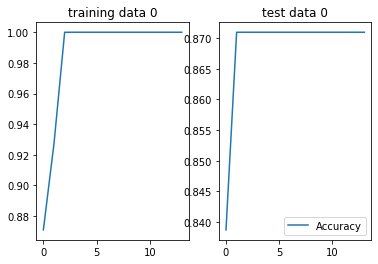

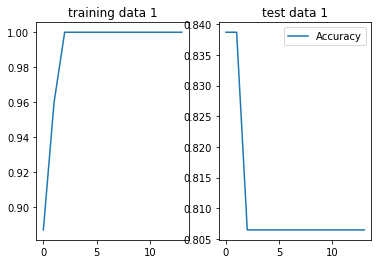

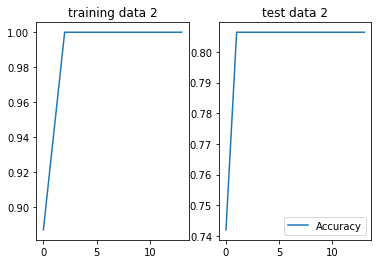

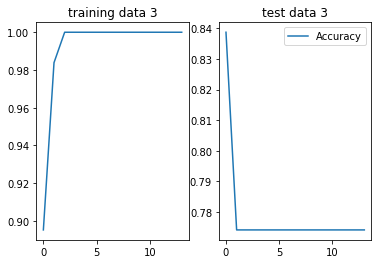

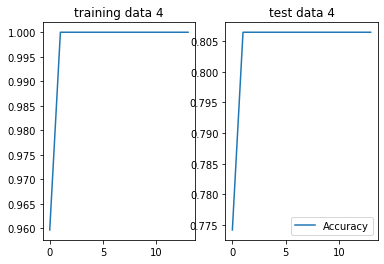

In [40]:
print(m)
for i in range(ita):
    # err.shape
    m = train_errors[i].shape[0]
    xx = np.array(list(range(0,m)))
    xx = xx.reshape(m,1)
    ax = plt.subplot(1, 2, 1)
    ax.plot(xx, train_errors[i].reshape(m,1), label = "Accuracy")
    # plt.plot(xx, y_pred.reshape(m,1), label = "Predicted")
    # plt.plot(xx[0:506], y1_pred.reshape(m,1)[0:506], label = "Library")
    # plt.xlabel('x - axis')
    # plt.ylabel('Accuracy')
    ax.set_title('training data ' + str(i))

    mm = test_errors[i].shape[0]
    ax = plt.subplot(1, 2, 2)
    ax.plot(xx, test_errors[i].reshape(mm,1), label = "Accuracy")
    ax.set_title('test data ' + str(i))

    plt.legend()
    plt.show()

In [41]:
train_errors

[array([0.87096774, 0.92741935, 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        ]),
 array([0.88709677, 0.95967742, 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        ]),
 array([0.88709677, 0.94354839, 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        ]),
 array([0.89516129, 0.98387097, 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        ]),
 array([0.95967742, 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        ])]

In [42]:
test_errors

[array([0.83870968, 0.87096774, 0.87096774, 0.87096774, 0.87096774,
        0.87096774, 0.87096774, 0.87096774, 0.87096774, 0.87096774,
        0.87096774, 0.87096774, 0.87096774, 0.87096774]),
 array([0.83870968, 0.83870968, 0.80645161, 0.80645161, 0.80645161,
        0.80645161, 0.80645161, 0.80645161, 0.80645161, 0.80645161,
        0.80645161, 0.80645161, 0.80645161, 0.80645161]),
 array([0.74193548, 0.80645161, 0.80645161, 0.80645161, 0.80645161,
        0.80645161, 0.80645161, 0.80645161, 0.80645161, 0.80645161,
        0.80645161, 0.80645161, 0.80645161, 0.80645161]),
 array([0.83870968, 0.77419355, 0.77419355, 0.77419355, 0.77419355,
        0.77419355, 0.77419355, 0.77419355, 0.77419355, 0.77419355,
        0.77419355, 0.77419355, 0.77419355, 0.77419355]),
 array([0.77419355, 0.80645161, 0.80645161, 0.80645161, 0.80645161,
        0.80645161, 0.80645161, 0.80645161, 0.80645161, 0.80645161,
        0.80645161, 0.80645161, 0.80645161, 0.80645161])]